# Import libraries

In [1]:
pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Added imports 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.utils.convert import from_networkx, to_networkx

from MatrixVectorizer import MatrixVectorizer

/tmp/ipykernel_1567947/744373269.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Utility functions

In [3]:
def add_self_connections(A):
    """
    Add self-connections to the adjacency matrix.

    This function adds an identity matrix to the adjacency matrix `A`, which
    effectively adds a self-loop to each node in the graph. This is a common
    preprocessing step in graph neural network implementations.

    Parameters:
    A (np.ndarray): The adjacency matrix to modify.

    Returns:
    np.ndarray: The adjacency matrix with self-connections added.
    """
    I = torch.Tensor(np.eye(A.shape[0]))
    return A + I

In [4]:
def compute_ground_truth_metrics(gt_matrices):
    num_test_samples = gt_matrices.shape[0]

    # Initialize list to store metrics
    gt_metrics = []
    # Iterate over each test sample
    for i in range(num_test_samples):
        # Convert adjacency matrices to NetworkX graphs
        gt_graph = nx.from_numpy_array(MatrixVectorizer.anti_vectorize(gt_matrices[i], 268), edge_attr="weight")

        # Compute centrality measures
        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")

        gt_metrics.append((gt_bc, gt_ec, gt_pc))

    return gt_metrics

# Reproducibility

In [5]:
# Set a fixed random seed for reproducibility across multiple libraries
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


# Load data

In [6]:
lr_train_data = pd.read_csv("data/lr_train.csv")

In [7]:
hr_train_data = pd.read_csv("data/hr_train.csv")

In [8]:
def prepare_train_data_for_GSR(data, embedding_dim=160):
  data_list = []
  for i, g in enumerate(data.values):
    adjacency_matrix = add_self_connections(torch.Tensor(MatrixVectorizer.anti_vectorize(g, embedding_dim)))

    data_list.append(adjacency_matrix.numpy())
  
  return np.array(data_list)

lr_data_list = prepare_train_data_for_GSR(lr_train_data, embedding_dim=160)
hr_data_list = prepare_train_data_for_GSR(hr_train_data, embedding_dim=268)

In [9]:
ground_truth_metrics = compute_ground_truth_metrics(hr_train_data.values)

In [10]:
MatrixVectorizer.anti_vectorize(lr_train_data.values[0], 160)

array([[0.        , 0.33881717, 0.20248584, ..., 0.67018974, 0.3993646 ,
        0.12178811],
       [0.33881717, 0.        , 0.03983874, ..., 0.58988836, 0.        ,
        0.34501474],
       [0.20248584, 0.03983874, 0.        , ..., 0.32471065, 0.16564857,
        0.00650767],
       ...,
       [0.67018974, 0.58988836, 0.32471065, ..., 0.        , 0.26329527,
        0.25529165],
       [0.3993646 , 0.        , 0.16564857, ..., 0.26329527, 0.        ,
        0.18337431],
       [0.12178811, 0.34501474, 0.00650767, ..., 0.25529165, 0.18337431,
        0.        ]])

In [11]:
add_self_connections(torch.Tensor(MatrixVectorizer.anti_vectorize(lr_train_data.values[0], 160)))

tensor([[1.0000, 0.3388, 0.2025,  ..., 0.6702, 0.3994, 0.1218],
        [0.3388, 1.0000, 0.0398,  ..., 0.5899, 0.0000, 0.3450],
        [0.2025, 0.0398, 1.0000,  ..., 0.3247, 0.1656, 0.0065],
        ...,
        [0.6702, 0.5899, 0.3247,  ..., 1.0000, 0.2633, 0.2553],
        [0.3994, 0.0000, 0.1656,  ..., 0.2633, 1.0000, 0.1834],
        [0.1218, 0.3450, 0.0065,  ..., 0.2553, 0.1834, 1.0000]])

# Define function to get evaluation metrics

In [12]:
def get_evaluation_metrics(pred_matrices, gt_matrices, computed_gt_metrics=None, graph_metrics=True):
    """
    Calculate evaluation metrics for predicted and ground truth matrices.

    Args:
    pred_matrices (np.ndarray): Array of predicted adjacency matrices.
    gt_matrices (np.ndarray): Array of ground truth adjacency matrices.
    computed_gt_metrics (list, optional): List of precomputed ground truth centrality metrics. 
    Defaults to None.
    graph_metrics (bool, optional): Flag to indicate whether to compute individual graph centrality metrics. 
    Defaults to True.

    Returns:
    tuple: A tuple containing the following evaluation metrics:
        - Mean Absolute Error (MAE) between predicted and ground truth matrices.
        - Pearson Correlation Coefficient (PCC) between predicted and ground truth matrices.
        - Jensen-Shannon Distance (JSD) between predicted and ground truth matrices.
        - Average MAE for betweenness centrality.
        - Average MAE for eigenvector centrality.
        - Average MAE for PageRank centrality.
    """

    num_test_samples = gt_matrices.shape[0]
    num_roi = 268
    pred_1d_list = []
    gt_1d_list = []
    for i in range(num_test_samples):
        # Vectorize matrices
        pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(gt_matrices[i]))

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)

    # If individual metrics are not requested, return the global metrics only to save time
    if not graph_metrics:
        return mae, pcc, js_dis

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []

    # Iterate over each test sample
    for i in range(num_test_samples):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")

        if computed_gt_metrics is None:
            gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")
            gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
            gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
            gt_pc = nx.pagerank(gt_graph, weight="weight")
        else:
            gt_bc, gt_ec, gt_pc = computed_gt_metrics[i]

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc

# Create submodels

In this section we define all the building blocks of the Graph2Graph model and then use them to create the final architecture.

## Part 1: Define GraphUNet and GSRLayer

In [13]:
def weight_variable_glorot(output_dim):
    """
    Initialize weights using Glorot initialization.

    Args:
    output_dim (int): The dimension of the output.

    Returns:
    np.ndarray: An array of weights initialized using Glorot initialization.
    """

    input_dim = output_dim
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = np.random.uniform(-init_range, init_range,
                                (input_dim, output_dim))

    return initial

def normalize_adj_torch(mx):
    """
    Normalize the input adjacency matrix using symmetric normalization.

    Args:
    mx (torch.Tensor): Input adjacency matrix.

    Returns:
    torch.Tensor: Normalized adjacency matrix.
    """
    rowsum = mx.sum(1)
    r_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
    r_inv_sqrt[torch.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = torch.diag(r_inv_sqrt)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    mx = torch.transpose(mx, 0, 1)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    return mx

class GSRLayer(nn.Module):
    """
    Graph Super-Resolution Layer.

    Args:
    hr_dim (int): The dimension of the high-resolution input.

    Attributes:
    weights (torch.nn.Parameter): Learnable weights for the layer.

    Methods:
    forward(A, X, device=None): Performs the forward pass of the layer.

    Returns:
    tuple: A tuple containing the following:
        - The normalized adjacency matrix.
        - The processed high-resolution input.
    """

    def __init__(self, hr_dim):
        super(GSRLayer, self).__init__()

        self.weights = torch.from_numpy(
            weight_variable_glorot(hr_dim)).type(torch.FloatTensor)
        self.weights = torch.nn.Parameter(
            data=self.weights, requires_grad=True)

    def forward(self, A, X, device=None):
        """
        Perform the forward pass of the Graph Super-Resolution Layer.

        Args:
        A (torch.Tensor): Input adjacency matrix.
        X (torch.Tensor): Input high-resolution data.
        device (torch.device, optional): The device to be used for computation. Defaults to None.

        Returns:
        tuple: A tuple containing the following:
            - The normalized adjacency matrix.
            - The processed high-resolution input.
        """

        lr = A
        lr_dim = lr.shape[0]
        f = X
        eig_val_lr, U_lr = torch.linalg.eigh(lr, UPLO='U')

        # U_lr = torch.abs(U_lr)
        eye_mat = torch.eye(lr_dim, device=device).type(torch.FloatTensor)
        s_d = torch.cat((eye_mat, eye_mat), 0)

        if device is not None:
            s_d = s_d.to(device)
            U_lr = U_lr.to(device)

        a = torch.matmul(self.weights, s_d)
        b = torch.matmul(a, torch.t(U_lr))
        f_d = torch.matmul(b, f)
        f_d = torch.abs(f_d)
        f_d = f_d.fill_diagonal_(1)
        adj = normalize_adj_torch(f_d)

        X = torch.mm(adj, adj.t())
        X = (X + X.t())/2
        X = X.fill_diagonal_(1)
        return adj, torch.abs(X)

class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, dropout, act=F.relu):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.act = act
        self.weight = torch.nn.Parameter(
            torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        """
        Perform the forward pass of the GraphConvolution layer.

        Args:
        input (torch.Tensor): Input feature matrix.
        adj (torch.Tensor): Input adjacency matrix.

        Returns:
        torch.Tensor: The output of the GraphConvolution layer.
        """
        if self.training and self.dropout > 0:
            input = F.dropout(input, self.dropout, self.training)
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        if self.act is not None:
            output = self.act(output)
        return output

In [14]:
import torch
import torch.nn as nn
import numpy as np


class GraphUnpool(nn.Module):
    """
    Graph Unpooling Layer.

    Methods:
    forward(A, X, idx, device=None): Performs the forward pass of the layer.

    Returns:
    tuple: A tuple containing the following:
        - The original adjacency matrix.
        - The unpooling result of the input feature matrix.
    """

    def __init__(self):
        super(GraphUnpool, self).__init__()

    def forward(self, A, X, idx, device=None):
        """
        Perform the forward pass of the Graph Unpooling Layer.

        Args:
        A (torch.Tensor): Input adjacency matrix.
        X (torch.Tensor): Input feature matrix.
        idx (torch.Tensor): Indices for unpooling.
        device (torch.device, optional): The device to be used for computation. Defaults to None.

        Returns:
        tuple: A tuple containing the following:
            - The original adjacency matrix.
            - The unpooling result of the input feature matrix.
        """
        new_X = torch.zeros([A.shape[0], X.shape[1]], device=device)
        new_X[idx] = X
        return A, new_X

class GraphPool(nn.Module):
    """
    Graph Pooling Layer.

    Args:
    k (float): The ratio of nodes to keep after pooling.
    in_dim (int): The dimension of the input feature matrix.

    Methods:
    forward(A, X): Performs the forward pass of the layer.

    Returns:
    tuple: A tuple containing the following:
        - The pooled adjacency matrix.
        - The pooled feature matrix.
        - The indices of the pooled nodes.
    """

    def __init__(self, k, in_dim):
        super(GraphPool, self).__init__()
        self.k = k
        self.proj = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, A, X):
        """
        Perform the forward pass of the Graph Pooling Layer.

        Args:
        A (torch.Tensor): Input adjacency matrix.
        X (torch.Tensor): Input feature matrix.

        Returns:
        tuple: A tuple containing the following:
            - The pooled adjacency matrix.
            - The pooled feature matrix.
            - The indices of the pooled nodes.
        """
        scores = self.proj(X)
        # scores = torch.abs(scores)
        scores = torch.squeeze(scores)
        scores = self.sigmoid(scores/100)
        num_nodes = A.shape[0]
        values, idx = torch.topk(scores, int(self.k*num_nodes))
        new_X = X[idx, :]
        values = torch.unsqueeze(values, -1)
        new_X = torch.mul(new_X, values)
        A = A[idx, :]
        A = A[:, idx]
        return A, new_X, idx


class GCN(nn.Module):
    """
    Simple Graph Convolutional Network (GCN) layer.

    Args:
    in_dim (int): The dimension of the input feature matrix.
    out_dim (int): The dimension of the output feature matrix.

    Methods:
    forward(A, X, device=None): Performs the forward pass of the layer.

    Returns:
    torch.Tensor: The output of the GCN layer.
    """

    def __init__(self, in_dim, out_dim):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.drop = nn.Dropout(p=0)

    def forward(self, A, X, device=None):
        """
        Perform the forward pass of the Graph Convolutional Network (GCN) layer.

        Args:
        A (torch.Tensor): Input adjacency matrix.
        X (torch.Tensor): Input feature matrix.
        device (torch.device, optional): The device to be used for computation. Defaults to None.

        Returns:
        torch.Tensor: The output of the GCN layer.
        """
        if device is not None:
            A = A.to(device)
            X = X.to(device)
        X = self.drop(X)
        X = torch.matmul(A, X)
        X = self.proj(X)
        return X


class GraphUnet(nn.Module):
    """
    GraphUnet model for graph data.

    Args:
    ks (list): List of ratios for graph pooling.
    in_dim (int): The dimension of the input feature matrix.
    out_dim (int): The dimension of the output feature matrix.
    dim (int): The dimension parameter. Defaults to 320.

    Methods:
    forward(A, X, device=None): Performs the forward pass of the model.

    Returns:
    torch.Tensor: The output of the GraphUnet model.
    """

    def __init__(self, ks, in_dim, out_dim, dim=320):
        super(GraphUnet, self).__init__()
        self.ks = ks

        self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.l_n = len(ks)
        
        self.down_gcns.append(GCN(in_dim, dim))
        for i in range(self.l_n):
            self.down_gcns.append(GCN(dim, dim))
            self.pools.append(GraphPool(ks[i], dim))

        for i in range(self.l_n):
            self.up_gcns.append(GCN(dim, dim))
            self.unpools.append(GraphUnpool())
        self.up_gcns.append(GCN(dim*2, out_dim))

    def forward(self, A, X, device=None):
        """
        Perform the forward pass of the GraphUnet model.

        Args:
        A (torch.Tensor): Input adjacency matrix.
        X (torch.Tensor): Input feature matrix.
        device (torch.device, optional): The device to be used for computation. Defaults to None.

        Returns:
        torch.Tensor: The output of the GraphUnet model.
        """
        X = self.down_gcns[0](A, X, device=device)
        start_gcn_outs = X
        org_X = X

        adj_ms = [A]
        indices_list = []
        down_outs = [X]

        for i in range(1, self.l_n+1):

            A, X, idx = self.pools[i-1](A, X)
            X = self.down_gcns[i](A, X, device=device)
            if i < self.l_n:
                adj_ms.append(A)
                down_outs.append(X)
            indices_list.append(idx)

        for i in range(self.l_n):
            up_idx = self.l_n - i - 1

            A, idx = adj_ms[up_idx], indices_list[up_idx]
            A, X = self.unpools[i](A, X, idx, device=device)
            X = self.up_gcns[i](A, X)
            X = X.add(down_outs[up_idx])
        X = torch.cat([X, org_X], 1)
        X = self.up_gcns[-1](A, X, device=device)

        return X, start_gcn_outs

## Part 2: Create Graph Discriminator

In [15]:
class GraphDiscriminator(nn.Module):
    """
    Graph Discriminator model.

    Args:
    args (dict): Dictionary of arguments.

    Methods:
    forward(inputs, adj): Performs the forward pass of the model.

    Returns:
    torch.Tensor: The output of the Graph Discriminator model.
    """
    def __init__(self, args):
        super(GraphDiscriminator, self).__init__()
        self.hr_dim = args["hr_dim"]
        self.hidden_dim = args["hidden_dim"]
        self.gc1 = GraphConvolution(
            self.hr_dim, self.hidden_dim, 0.1, act=None
        )
        self.act1 = nn.LeakyReLU(negative_slope=0.2, inplace=False)
        self.gc2 = GraphConvolution(
            self.hidden_dim, 1, 0.1, act=None
        )

    def forward(self, inputs, adj):
        """
        Perform the forward pass of the Graph Discriminator model.

        Args:
        inputs (torch.Tensor): Input data.
        adj (torch.Tensor): Input adjacency matrix.

        Returns:
        torch.Tensor: The output of the Graph Discriminator model.
        """
        z = self.gc1(inputs, adj)
        z = self.act1(z)
        z = self.gc2(z, adj)

        return torch.abs(z)

# Our model: Graph2Graph

In [16]:
from functools import partial

def normalize_adj_torch(mx):
    """
    Normalize the input adjacency matrix using symmetric normalization.

    Args:
    mx (torch.Tensor): Input adjacency matrix.

    Returns:
    torch.Tensor: Normalized adjacency matrix.
    """
    rowsum = mx.sum(1)
    r_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
    r_inv_sqrt[torch.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = torch.diag(r_inv_sqrt)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    mx = torch.transpose(mx, 0, 1)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    return mx

def unpad(data, split):
    """
    Unpad the input data matrix.

    Args:
    data (numpy.ndarray): Input data matrix.
    split (int): Number of rows and columns to remove from each side.

    Returns:
    numpy.ndarray: Unpadded data matrix.
    """
    idx_0 = data.shape[0]-split
    idx_1 = data.shape[1]-split
    train = data[split:idx_0, split:idx_1]
    return train

def gaussian_noise_layer(input_layer, args):
    """
    Add Gaussian noise to the input layer.

    Args:
    input_layer (torch.Tensor): Input data matrix.
    args (dict): Dictionary of arguments containing mean and standard deviation for the noise.

    Returns:
    torch.Tensor: Input layer with added Gaussian noise.
    """
    z = torch.empty_like(input_layer)
    noise = z.normal_(mean=args["mean_gaussian"], std=args["std_gaussian"])
    z = torch.abs(input_layer + noise)

    z = (z + z.t())/2
    z = z.fill_diagonal_(1)
    return z

class Graph2Graph(nn.Module):
    """
    Graph2Graph model for graph data.

    Args:
    ks (list): List of ratios for graph pooling.
    args (dict): Dictionary of arguments.

    Methods:
    forward(lr, lr_dim, hr_dim, device=None): Performs the forward pass of the model.

    Returns:
    tuple: A tuple containing the following:
        - The processed adjacency matrix.
        - The output of the GraphUnet model.
        - The start output of the GraphConvolution layer.
        - The final output of the model.
    """

    def __init__(self, ks, args):
        super(Graph2Graph, self).__init__()

        self.lr_dim = args["lr_dim"]
        self.hr_dim = args["hr_dim"]
        self.hidden_dim = args["hidden_dim"]
        self.layer = GSRLayer(self.hr_dim)
        self.net = GraphUnet(ks, self.lr_dim, self.hr_dim)
        self.gc1 = GraphConvolution(
            self.hr_dim, self.hidden_dim, 0.2, act=partial(F.leaky_relu, negative_slope=0.2)
        )
        self.gc2 = GraphConvolution(
            self.hidden_dim, self.hr_dim, 0.2, act=partial(F.leaky_relu, negative_slope=0.2)
        )

    def forward(self, lr, lr_dim, hr_dim, device=None):
        """
        Perform the forward pass of the Graph2Graph model.

        Args:
        lr (torch.Tensor): Low-resolution input data.
        lr_dim (int): Dimension of the low-resolution input.
        hr_dim (int): Dimension of the high-resolution input.
        device (torch.device, optional): The device to be used for computation. Defaults to None.

        Returns:
        tuple: A tuple containing the following:
            - The processed adjacency matrix.
            - The output of the GraphUnet model.
            - The start output of the GraphConvolution layer.
            - The final output of the model.
        """
        I = torch.eye(self.lr_dim, device=device).type(torch.FloatTensor)
        A = normalize_adj_torch(lr).type(torch.FloatTensor)

        if device is not None:
            A = A.to(device)

        self.net_outs, self.start_gcn_outs = self.net(A, I, device=device)

        self.outputs, self.Z = self.layer(A, self.net_outs, device=device)

        z = self.gc1(self.Z, self.outputs)
        z = self.gc2(z, self.outputs)
        
        z = (z + z.t())/2
        z = z.fill_diagonal_(1)

        return torch.abs(z), self.net_outs, self.start_gcn_outs, self.outputs
    
    def predict(self, lr_data, lr_dim, hr_dim, padding, device=None):
        """
        Generate predictions for the given low-resolution data.

        Args:
        lr_data (list): List of low-resolution input data.
        lr_dim (int): Dimension of the low-resolution input.
        hr_dim (int): Dimension of the high-resolution input.
        padding (int): Number of rows and columns to remove from each side.
        device (torch.device, optional): The device to be used for computation. Defaults to None.

        Returns:
        list: List of predicted high-resolution data.
        """
        predictions = []
        for lr in lr_data:
            lr = torch.from_numpy(lr).type(torch.FloatTensor)
            if device is not None:
                lr = lr.to(device)
            preds = self.forward(lr, lr_dim, hr_dim, device=device)[0]
            preds[preds < 0] = 0
            preds = unpad(preds, padding).detach().cpu().numpy()
            predictions.append(preds)
        return predictions

# Train model

In this section we define the hyperparameters used the Graph2Graph model and define the training function of the model.

In [17]:
args = {
    'epochs': 80,
    'lr': 0.001,
    'lmbda': 0.1,
    'lr_dim': 160,
    'hr_dim': 320,
    'hidden_dim': 320,
    'padding': 26,
    'mean_dense': 0.0,
    'std_dense': 0.01,
    'mean_gaussian': 0.0,
    'std_gaussian': 0.1,
    "dropout_rate": 0.01,
    'beta': 1,
}

ks = [0.9, 0.7, 0.6, 0.5]

In [18]:
import torch.optim as optim

def pad_HR_adj(label, split):
    """
    Pad the high-resolution adjacency matrix.

    Args:
    label (numpy.ndarray): High-resolution adjacency matrix.
    split (int): Number of rows and columns to pad on each side.

    Returns:
    numpy.ndarray: Padded high-resolution adjacency matrix.
    """
    label = np.pad(label, ((split, split), (split, split)), mode="constant")
    np.fill_diagonal(label, 1)
    return label

def train_g2g(model, subjects_adj, subjects_labels, args, val_adj=None, val_labels=None, device=None):
    """
    Train the Graph2Graph model using the provided data and parameters.

    Args:
    model (Graph2Graph): The Graph2Graph model to be trained.
    subjects_adj (list): List of adjacency matrices for training subjects.
    subjects_labels (list): List of label matrices for training subjects.
    args (dict): Dictionary of training arguments and hyperparameters.
    val_adj (list, optional): List of adjacency matrices for validation subjects. Defaults to None.
    val_labels (list, optional): List of label matrices for validation subjects. Defaults to None.
    device (torch.device, optional): The device to be used for computation. Defaults to None.

    Returns:
    list or tuple: List of training evaluation metrics or tuple containing training 
    and validation evaluation metrics.
    """
    criterion = nn.L1Loss()
    bce_loss = nn.BCEWithLogitsLoss()
    netD = GraphDiscriminator(args)
    if device is not None:
        model = model.to(device)
        netD = netD.to(device)
    optimizerG = optim.Adam(model.parameters(), lr=args["lr"])
    optimizerD = optim.Adam(netD.parameters(), lr=args["lr"])
    schedulerG = optim.lr_scheduler.ReduceLROnPlateau(optimizerG, 'min', patience=3, factor=0.5)
    schedulerD = optim.lr_scheduler.ReduceLROnPlateau(optimizerD, 'min', patience=3, factor=0.5)

    all_epochs_loss = []
    train_evaluation_metrics = []
    val_evaluation_metrics = []
    for epoch in range(args["epochs"]):
        epoch_loss = []
        epoch_error = []
        g_loss = []
        d_loss = []
        model.train()

        # Shuffle the data so that the order of subjects is different in each epoch
        order = list(range(len(subjects_adj)))
        random.shuffle(order)
        for index in order:
            lr = subjects_adj[index]
            hr = subjects_labels[index]
 
            optimizerD.zero_grad()
            optimizerG.zero_grad()

            padded_hr = pad_HR_adj(hr, args["padding"])
            lr = torch.from_numpy(lr).type(torch.FloatTensor)
            padded_hr = torch.from_numpy(padded_hr).type(torch.FloatTensor)

            # Add noise to input data
            noise_scales = 0.05 * torch.rand_like(lr)
            lr = lr + noise_scales * lr
            lr = torch.clip(lr, min=0, max=1)
            # Drop some of the nodes
            if args["dropout_rate"] > 0:
                mask = torch.bernoulli(torch.full((lr.shape[0],), args["dropout_rate"])).bool()
                lr[mask, :] = 0
                lr[:, mask] = 0
                lr[mask, mask] = 1

            if device is not None:
                lr = lr.to(device)
                padded_hr = padded_hr.to(device)

            # Eigen decomposition needed for the loss function
            eig_val_hr, U_hr = torch.linalg.eigh(
                padded_hr, UPLO='U')

            # Forward pass through the model
            model_outputs, net_outs, start_gcn_outs, layer_outs = model(
                lr, args["lr_dim"], args["hr_dim"], device=device)

            recon_loss = args["lmbda"] * criterion(net_outs, start_gcn_outs)
            eig_loss = criterion(model.layer.weights, U_hr)
            hr_loss = criterion(model_outputs, padded_hr)

            mse_loss = recon_loss + eig_loss + hr_loss

            error = criterion(model_outputs, padded_hr)
            real_data = model_outputs.detach()
            fake_data = torch.clip(gaussian_noise_layer(padded_hr, args), min=0, max=1)
            fake_adj = gaussian_noise_layer(layer_outs, args)

            if device is not None:
                real_data = real_data.to(device)
                fake_data = fake_data.to(device)

            # Forward pass through the discriminator
            d_real = netD(real_data, fake_adj)
            d_fake = netD(fake_data, fake_adj)

            # Smooth labels
            real_labels = torch.rand(args["hr_dim"], 1, device=device) * 0.3 + 0.7
            fake_labels = torch.rand(args["hr_dim"], 1, device=device) * 0.3

            # Swap real and fake labels with a small probability
            if torch.rand(1) < 0.05:
                real_labels, fake_labels = fake_labels, real_labels

            # Compute losses for discriminator and optimise
            dc_loss_real = bce_loss(d_real, real_labels)
            dc_loss_fake = bce_loss(d_fake, fake_labels)
            dc_loss = dc_loss_real + dc_loss_fake
            d_loss.append(dc_loss.item())

            dc_loss.backward(retain_graph=True)
            optimizerD.step()

            d_fake = netD(fake_data, fake_adj)

            # Compute losses for generator and optimise
            gen_loss = bce_loss(d_fake, real_labels)
            g_loss.append(gen_loss.item())

            generator_loss = gen_loss + args["beta"] * mse_loss
            generator_loss.backward()

            optimizerG.step()
            epoch_loss.append(generator_loss.item())

            epoch_error.append(error.item())

        print("Epoch: ", epoch, "Loss: ", np.mean(epoch_loss), 
              "G Loss: ", np.mean(g_loss), "D Loss: ", np.mean(d_loss),
                "Error: ", np.mean(epoch_error)*100, "%")
        all_epochs_loss.append(np.mean(epoch_loss))
        
        # Compute and store evaluation metrics
        model.eval()
        print('Train evaluation metrics:')
        predictions_train = model.predict(subjects_adj, args["lr_dim"], args["hr_dim"], args["padding"], device)
        train_evaluation_metrics.append(get_evaluation_metrics(predictions_train, subjects_labels, computed_gt_metrics=None, graph_metrics=False))
        if val_adj is not None:
            print('Val evaluation metrics:')
            predictions_val = model.predict(val_adj, args["lr_dim"], args["hr_dim"], args["padding"], device)
            val_evaluation_metrics.append(get_evaluation_metrics(predictions_val, val_labels, computed_gt_metrics=None, graph_metrics=False))
            schedulerD.step(val_evaluation_metrics[-1][0])
            schedulerG.step(val_evaluation_metrics[-1][0])
        else:
            schedulerD.step(np.mean(d_loss))
            schedulerG.step(np.mean(epoch_loss))
        print('-'*10)
    if val_adj is None:
        return train_evaluation_metrics
    return train_evaluation_metrics, val_evaluation_metrics

# Cross-Validation setup

In [19]:
def k_fold_cross_validation(lr_train_data, hr_train_data, ground_truth_metrics, hyperparameters=args, k=3, graph_metrics=False, plot_losses=False):
    print("Starting k-fold cross-validation...")
    print("Hyperparameters:")
    for key, value in hyperparameters.items():
        print(f"\t{key}: {value}")

    data_array = prepare_train_data_for_GSR(lr_train_data, embedding_dim=160)
    hr_data_array = prepare_train_data_for_GSR(hr_train_data, embedding_dim=268)

    # Create a KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    # Initialize lists to store predictions and evaluation results for each fold
    all_predictions = []
    all_evaluation_results = []
    folds_evaluations = []

    # Perform cross-validation
    for fold_num, (train_index, test_index) in enumerate(kf.split(lr_train_data)):

        data_train, data_val = data_array[train_index], data_array[test_index]
        hr_data_train, hr_data_val = hr_data_array[train_index], hr_data_array[test_index]

        train_gt_metrics = [ground_truth_metrics[i] for i in train_index.tolist()]
        val_gt_metrics = [ground_truth_metrics[i] for i in test_index.tolist()]

        # Create an instance of model
        model = Graph2Graph(ks, args)
        
        # Train the model
        train_metrics, val_metrics = train_g2g(model, data_train, hr_data_train, args, data_val, hr_data_val, device)
        folds_evaluations.append((train_metrics, val_metrics))
        
        # Make predictions
        predictions = model.predict(data_val, hyperparameters["lr_dim"], hyperparameters["hr_dim"], hyperparameters["padding"], device)

        # Append predictions for evaluation
        pred_vectors = torch.stack([torch.Tensor(MatrixVectorizer.vectorize(preds)) for preds in predictions])
        all_predictions.extend(pred_vectors)
        
        # Step I: Flatten the prediction matrix
        flattened_predictions = pred_vectors.flatten()

        # Step II: Create a DataFrame with 'ID' and 'Predicted' columns
        df = pd.DataFrame({'ID': range(1, len(flattened_predictions) + 1), 'Predicted': flattened_predictions})

        # Step III: Save the DataFrame to a CSV file
        df.to_csv(f'predictions_fold_{fold_num + 1}.csv', index=False)

        # Print message and append evaluation results
        print(f'Submission file "predictions_fold_{fold_num + 1}.csv" created successfully.')
        all_evaluation_results.append(get_evaluation_metrics(np.array(predictions), hr_data_val, val_gt_metrics, graph_metrics=graph_metrics))
        
    return all_predictions, all_evaluation_results, predictions[0], hr_data_val[0], folds_evaluations

In [20]:
all_predictions, all_evaluation_results, example_predictions, example_ground_truth, folds_evaluations = k_fold_cross_validation(lr_train_data, hr_train_data, ground_truth_metrics, args, k=3, graph_metrics=True)

Starting k-fold cross-validation...
Hyperparameters:
	epochs: 80
	lr: 0.001
	lmbda: 0.1
	lr_dim: 160
	hr_dim: 320
	hidden_dim: 320
	padding: 26
	mean_dense: 0.0
	std_dense: 0.01
	mean_gaussian: 0.0
	std_gaussian: 0.1
	dropout_rate: 0.01
	beta: 1
Epoch:  0 Loss:  23.369908862285786 G Loss:  23.149349925754308 D Loss:  94.2770534184602 Error:  15.058211102947459 %
Train evaluation metrics:
MAE:  0.18537073
PCC:  0.250559115861152
Jensen-Shannon Distance:  0.34767463721181446
Val evaluation metrics:
MAE:  0.17970611
PCC:  0.25411523421600707
Jensen-Shannon Distance:  0.34450234099396915
----------
Epoch:  1 Loss:  11.117217544499818 G Loss:  10.919504408363823 D Loss:  69.47378354459195 Error:  13.716975894865687 %
Train evaluation metrics:
MAE:  0.17919058
PCC:  0.27516487663283534
Jensen-Shannon Distance:  0.34233214835318115
Val evaluation metrics:
MAE:  0.17308578
PCC:  0.2847122084265305
Jensen-Shannon Distance:  0.33786325950278917
----------
Epoch:  2 Loss:  12.852176408509951 G Lo

# Evaluation

Using the data from the cross validation, we will plot the evaluation metrics for each fold and the average of all folds.

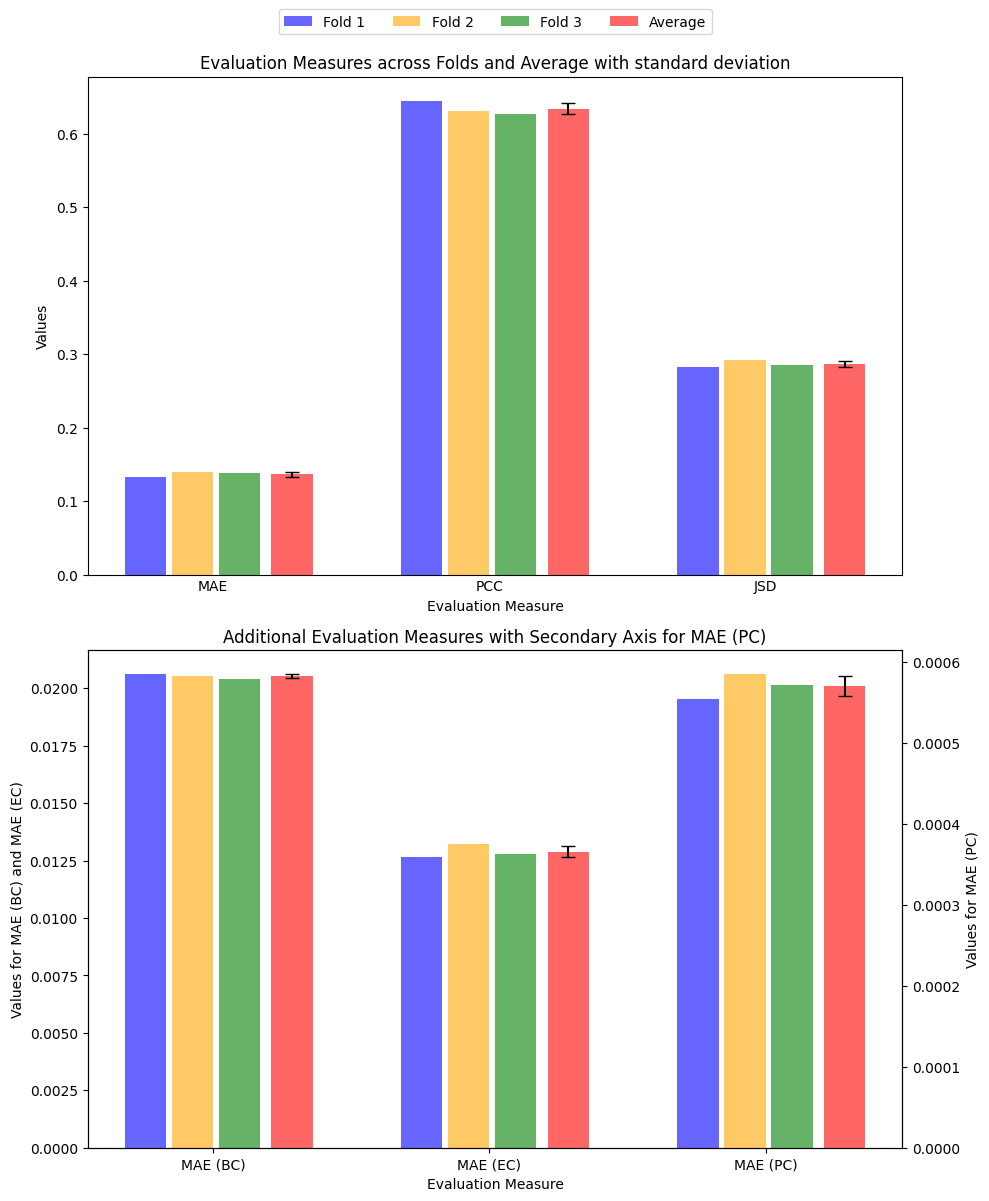

In [21]:
colors = ['blue', 'orange', 'green', 'red']  # Colors for each fold and the average
evaluation_measures = ['MAE', 'PCC', 'JSD', 'MAE (BC)', 'MAE (EC)', 'MAE (PC)']

# Splitting the evaluation measures
evaluation_measures_1 = evaluation_measures[:3]
evaluation_measures_2 = evaluation_measures[3:]
index_1 = np.arange(len(evaluation_measures_1))
index_2 = np.arange(len(evaluation_measures_2))

# Calculate averages and standard deviations
average_results = np.mean(all_evaluation_results, axis=0)
std_dev_results = np.std(all_evaluation_results, axis=0)

# Layout settings
bar_width = 0.15
opacity = 0.6
spacing = 0.02

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot for the first three metrics
for i in range(len(all_evaluation_results)):
    ax1.bar(index_1 + i * (bar_width + spacing), all_evaluation_results[i][:3], bar_width,
            alpha=opacity, label=f'Fold {i+1}', color=colors[i])
ax1.bar(index_1 + 3 * (bar_width + spacing) + spacing, average_results[:3], bar_width, yerr=std_dev_results[:3], alpha=opacity, capsize=5, label='Average', color=colors[-1])
ax1.set_xlabel('Evaluation Measure')
ax1.set_ylabel('Values')
ax1.set_title('Evaluation Measures across Folds and Average with standard deviation')
ax1.set_xticks(index_1 + 1.5 * bar_width + spacing)
ax1.set_xticklabels(evaluation_measures_1)
ax1.tick_params(axis='x', length=0)  # Remove x-tick marks
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)

# Second plot with a secondary y-axis for the MAE (PC) metric
mae_pc_index = len(evaluation_measures_2) - 1
all_evaluation_results_np = np.array(all_evaluation_results)

# Plotting all metrics except MAE (PC) on the first axis
for i in range(len(all_evaluation_results)):
    ax2.bar(index_2[:-1] + i * (bar_width + spacing), all_evaluation_results[i][3:5], bar_width,
            alpha=opacity, color=colors[i], label=f'Fold {i+1}' if i < 3 else 'Average')

# Plot the average bars except for MAE (PC)
ax2.bar(index_2[:-1] + 3 * (bar_width + spacing) + spacing, average_results[3:5], bar_width,
        yerr=std_dev_results[3:5], alpha=opacity, color=colors[-1], capsize=5)

ax2.set_xlabel('Evaluation Measure')
ax2.set_ylabel(f'Values for {evaluation_measures_2[0]} and {evaluation_measures_2[1]}')
ax2.set_title('Additional Evaluation Measures with Secondary Axis for MAE (PC)')
ax2.set_xticks(index_2 + 1.5 * bar_width + spacing)
ax2.set_xticklabels(evaluation_measures_2)

# Add secondary Y-axis for MAE (PC)
ax3 = ax2.twinx()
for i in range(len(all_evaluation_results)):
    ax3.bar(index_2[mae_pc_index] + i * (bar_width + spacing), all_evaluation_results_np[i][3+mae_pc_index], bar_width,
            alpha=opacity, color=colors[i])

# Plot the average bar for MAE (PC) on the secondary axis
ax3.bar(index_2[mae_pc_index] + 3 * (bar_width + spacing) + spacing, average_results[3+mae_pc_index], bar_width,
        yerr=std_dev_results[3+mae_pc_index], alpha=opacity, color=colors[-1], capsize=5)
ax3.set_ylabel('Values for MAE (PC)')

# Adjust layout for the combined figure
fig.tight_layout()
plt.show()

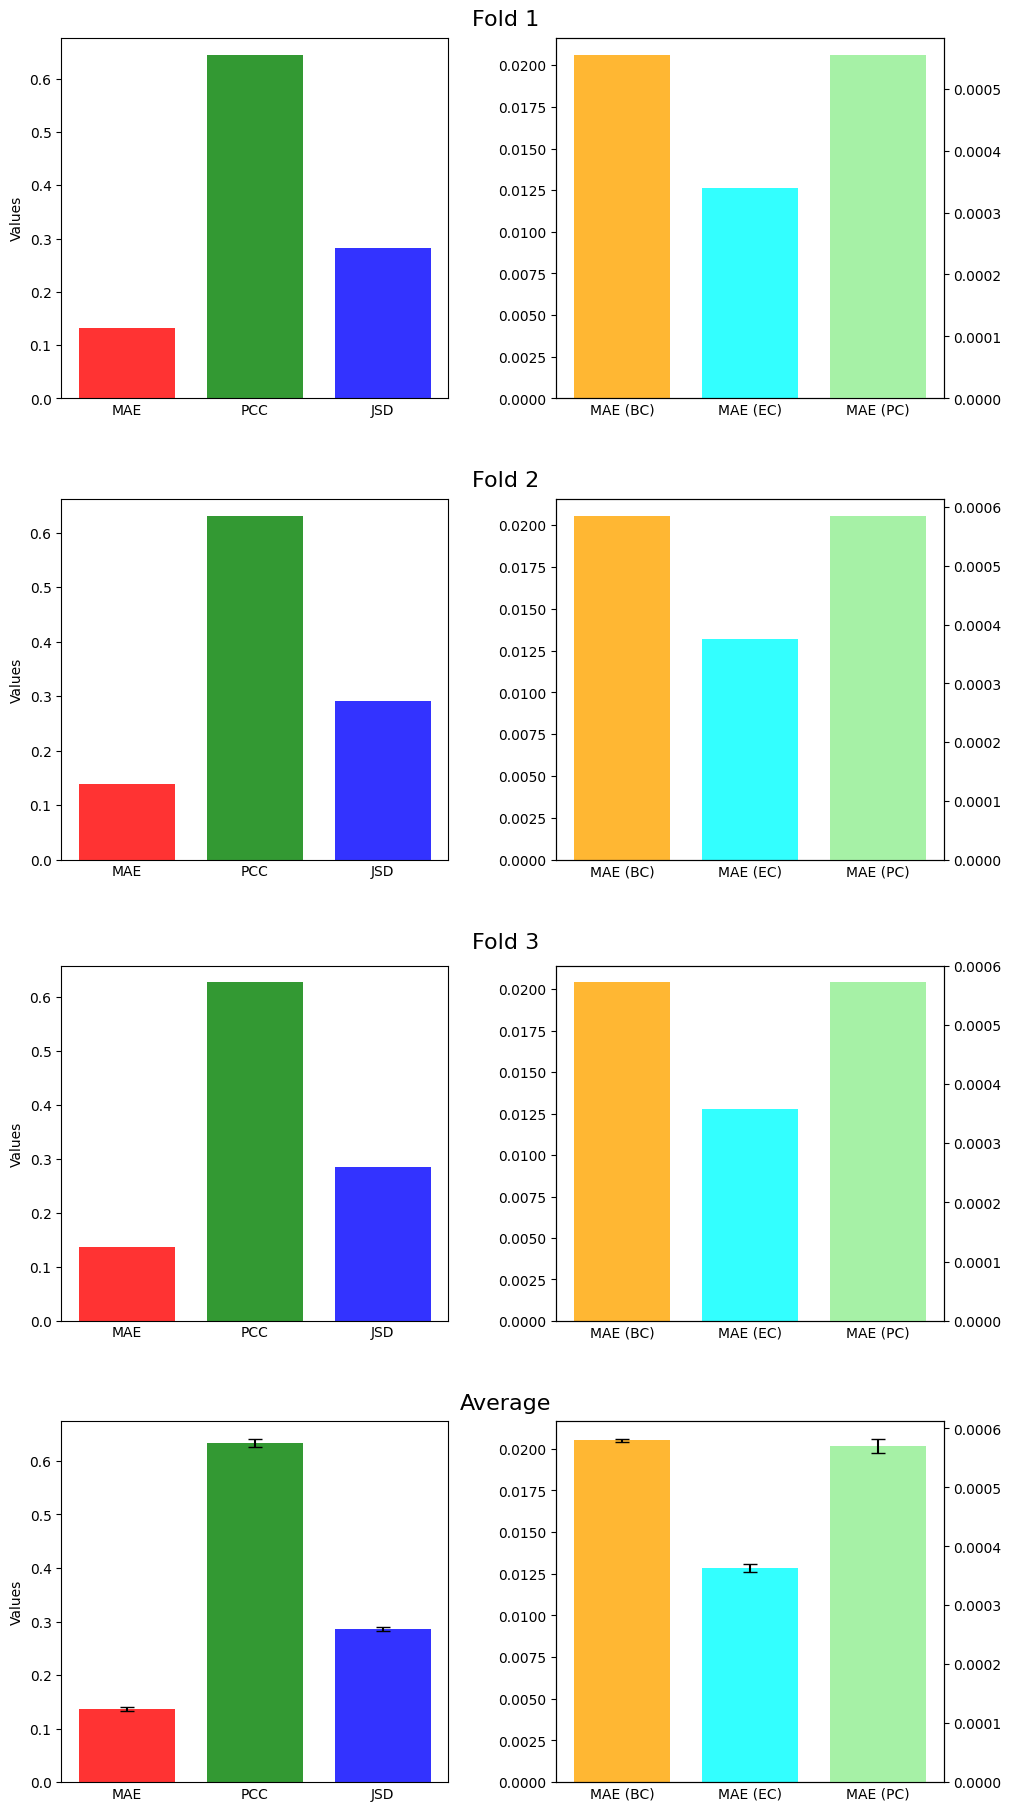

In [22]:
# Splitting the evaluation measures and their corresponding results into two sets for better visualization
evaluation_measures = ['MAE', 'PCC', 'JSD', 'MAE (BC)', 'MAE (EC)', 'MAE (PC)']
evaluation_measures_1 = evaluation_measures[:3]  # First set of metrics
evaluation_measures_2 = evaluation_measures[3:]  # Second set of metrics
index_1 = np.arange(len(evaluation_measures_1)) * 0.4
index_2 = np.arange(len(evaluation_measures_1)) * 0.4
colors = ['red', 'green', 'blue', 'orange', 'cyan', 'lightgreen'] # Colors for each metric

# Calculate the average results and standard deviation across folds for each measure
average_results = np.mean(all_evaluation_results, axis=0)
std_dev_results = np.std(all_evaluation_results, axis=0)

# Layout settings
bar_width = 0.3
opacity = 0.8

# Plotting
fig = plt.figure(constrained_layout=True, figsize=(10, 18))
gs = fig.add_gridspec(nrows=4, ncols=1, hspace=0.1)
subfigs = [fig.add_subfigure(gs[i]) for i in range(4)] # 4 rows for each fold and the average, 2 columns for two sets of metrics for better visualisation

# Loop through each fold and the average
for fold_index, subfig in enumerate(subfigs):
    subfig.suptitle(f'Fold {fold_index + 1}' if fold_index < 3 else 'Average', fontsize=16)

    axs = subfig.subplots(nrows=1, ncols=2, gridspec_kw={'wspace': 0.1})

    results = all_evaluation_results[fold_index] if fold_index < 3 else average_results
    # First set of metrics
    axs[0].bar(index_1, results[:3], bar_width, yerr=std_dev_results[:3] if fold_index == 3 else None, alpha=opacity, capsize=5, color=colors[:3])
    axs[0].set_ylabel('Values')
    axs[0].set_xticks(index_1)
    axs[0].set_xticklabels(evaluation_measures_1)
    axs[0].tick_params(axis='x', length=0)

    # Second set of metrics
    axs[1].bar(index_2[:-1], results[3:5], bar_width, yerr=std_dev_results[3:5] if fold_index == 3 else None, alpha=opacity, capsize=5, color=colors[3:5])
    ax3 = axs[1].twinx()
    ax3.bar(index_2[-1], results[-1], bar_width, yerr=std_dev_results[-1] if fold_index == 3 else None, alpha=opacity, capsize=5, color=colors[-1])

    axs[1].set_xticks(index_2)
    axs[1].set_xticklabels(evaluation_measures_2)
    axs[1].tick_params(axis='x', length=0)

plt.show()

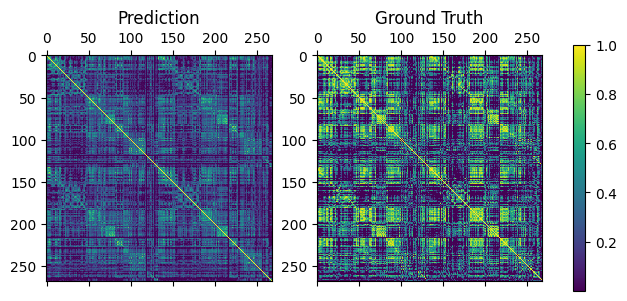

In [23]:
# check 1 example

# Find the maximum value among both matrices to set a common colorbar scale
max_value = 1

adjacency_matrix_1 = add_self_connections(torch.Tensor(example_predictions)).numpy()
adjacency_matrix_2 = add_self_connections(torch.Tensor(example_ground_truth)).numpy()
# Create a figure and axes
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first adjacency matrix with a blue colormap
cax1 = axs[0].matshow(adjacency_matrix_1, cmap='viridis', vmax=max_value)
axs[0].set_title('Prediction')
# Plot the second adjacency matrix with a blue colormap
cax2 = axs[1].matshow(adjacency_matrix_2, cmap='viridis', vmax=max_value)
axs[1].set_title('Ground Truth')


# Add a colorbar using the same scale for both matrices
cbar = fig.colorbar(cax1, ax=axs, shrink=0.8)

# Show the plot
plt.show()

In [24]:
all_evaluation_results

[(0.1321896,
  0.6446894620469853,
  0.28241232596012855,
  0.02062189099758811,
  0.012650457382748169,
  0.0005544940702540662),
 (0.13955162,
  0.6305564867108723,
  0.2916763025917321,
  0.020538261996237806,
  0.013204678857340826,
  0.0005849116705970359),
 (0.13776502,
  0.6268925941006405,
  0.28555460761542095,
  0.020408710477732597,
  0.01276922704435723,
  0.0005716110692022994)]

# Test model

In this section we retrain the model on the whole dataset, to take full advantage of the data available.

In [25]:
# Load test data
lr_test_data = pd.read_csv("data/lr_test.csv")

In [26]:
# Train model on all data
model = Graph2Graph(ks, args)
train_g2g(model, lr_data_list, hr_data_list, args, device=device)

Epoch:  0 Loss:  22.185097958156447 G Loss:  21.971333283328725 D Loss:  87.61061052219597 Error:  14.472383916556478 %
Train evaluation metrics:
MAE:  0.17630316
PCC:  0.2780149997328311
Jensen-Shannon Distance:  0.3408812984784124
----------
Epoch:  1 Loss:  9.285512135414306 G Loss:  9.099628673163716 D Loss:  49.63210815583874 Error:  13.147240368548982 %
Train evaluation metrics:
MAE:  0.17876458
PCC:  0.2786816385094978
Jensen-Shannon Distance:  0.3454565688409366
----------
Epoch:  2 Loss:  8.784364197068586 G Loss:  8.607208023885054 D Loss:  42.26719143861782 Error:  13.031293210869062 %
Train evaluation metrics:
MAE:  0.18165852
PCC:  0.25102689538414924
Jensen-Shannon Distance:  0.3491482490702416
----------
Epoch:  3 Loss:  8.053290616252465 G Loss:  7.880359428549955 D Loss:  37.98705648947619 Error:  12.981388646506979 %
Train evaluation metrics:
MAE:  0.17527695
PCC:  0.32020164892940217
Jensen-Shannon Distance:  0.33788330422998747
----------
Epoch:  4 Loss:  4.22792188

[(0.17630316, 0.2780149997328311, 0.3408812984784124),
 (0.17876458, 0.2786816385094978, 0.3454565688409366),
 (0.18165852, 0.25102689538414924, 0.3491482490702416),
 (0.17527695, 0.32020164892940217, 0.33788330422998747),
 (0.17306304, 0.315932188228779, 0.33853570737239824),
 (0.1738292, 0.31146593988441024, 0.3392605765520554),
 (0.17247939, 0.32224999781890357, 0.3382379367577571),
 (0.17236227, 0.32610672400198654, 0.33823621859814385),
 (0.17070976, 0.34469540944530463, 0.33559563341366194),
 (0.16534042, 0.41899217031311514, 0.327845908863558),
 (0.15257335, 0.5255434792800533, 0.31062380719483546),
 (0.14608009, 0.5702264912336379, 0.30153493458760705),
 (0.14443111, 0.5895836198353565, 0.298960712414534),
 (0.14395647, 0.5858418854314734, 0.29824340560254636),
 (0.14202854, 0.6016229710686691, 0.29597536352367104),
 (0.14297648, 0.6050960868846241, 0.29694102205673945),
 (0.1431971, 0.5972282256669975, 0.2950788421258552),
 (0.13985364, 0.6128602655317376, 0.29375555560763084)

In [27]:
# Make predictions
test_data_array = prepare_train_data_for_GSR(lr_test_data, embedding_dim=160)
preds_list = []
for lr in test_data_array:
    lr = torch.from_numpy(lr).type(torch.FloatTensor)
    preds, a, b, c = model(lr, args["lr_dim"], args["hr_dim"], device=device)
    preds[preds < 0] = 0
    preds = unpad(preds, args["padding"])
    preds_list.append(torch.Tensor(MatrixVectorizer.vectorize(preds.cpu().detach().numpy(), include_diagonal=False)))
predictions = torch.stack(preds_list)

We prepare data for submission in the format supported by the competition.

In [28]:
# Step I: Flatten the prediction matrix
flattened_predictions = predictions.flatten()

# Step II: Create a DataFrame with 'ID' and 'Predicted' columns
df = pd.DataFrame({'ID': range(1, len(flattened_predictions) + 1), 'Predicted': flattened_predictions})

# Step III: Save the DataFrame to a CSV file
df.to_csv(f'submission.csv', index=False)

# Display a summary or print a message
print(f'Submission file "submission.csv" created successfully.')

Submission file "submission.csv" created successfully.


In [29]:
!wc -l submission.csv

4007137 submission.csv


In [30]:
!head -15 submission.csv

ID,Predicted
1,0.59443367
2,0.56631154
3,0.7279973
4,0.5711657
5,0.6045773
6,0.4558098
7,0.4642648
8,0.4940455
9,0.76348907
10,0.27751154
11,0.6610942
12,0.5453081
13,0.6276844
14,0.44069076


### Exploring Invariance and Equivariance

We perform multiple experiments to explore the invariance and equivariance properties of our model. We consider predictions on a sample from the test set and compare with the prediction for the same sample after applying a permutation. We inspect the distribution in the edge weights and the node embeddings to understand these properties. We also perform a WL test to check whether the two predicitons are isomorphic graphs.

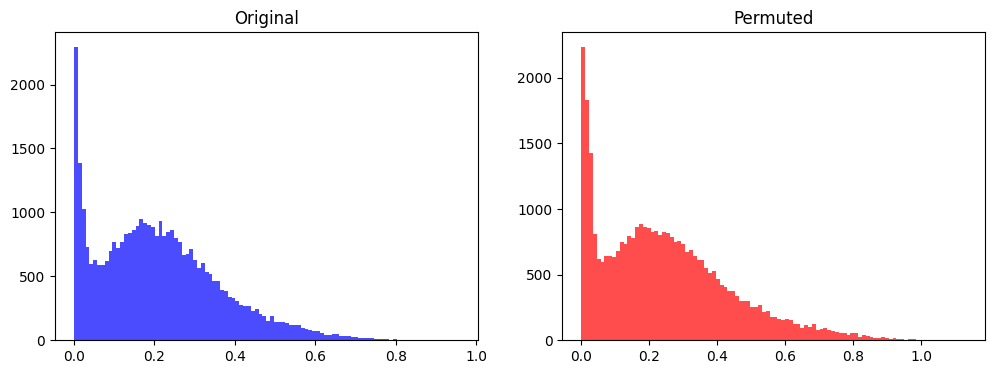

In [31]:
# Permutation matrix
model.eval()
permutation = torch.randperm(160)

# Convert to actual permutation matrix
permutation_matrix = torch.zeros((160, 160), device=device)
permutation_matrix[torch.arange(160), permutation] = 1

sample_adj = torch.from_numpy(test_data_array[0]).type(torch.FloatTensor).to(device)
permuted_adj = permutation_matrix @ sample_adj @ permutation_matrix.T

preds = model(sample_adj, args["lr_dim"], args["hr_dim"], device=device)[0]
preds[preds < 0] = 0
preds_m = unpad(preds, args["padding"])
preds = torch.Tensor(MatrixVectorizer.vectorize(preds_m.cpu().detach().numpy(), include_diagonal=False))

permuted_preds = model(permuted_adj, args["lr_dim"], args["hr_dim"], device=device)[0]
permuted_preds[permuted_preds < 0] = 0
permuted_preds_m = unpad(permuted_preds, args["padding"])
permuted_preds = torch.Tensor(MatrixVectorizer.vectorize(permuted_preds_m.cpu().detach().numpy(), include_diagonal=False))

# Plot the values as histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(preds, bins=100, color='blue', alpha=0.7)
axs[0].set_title('Original')
axs[1].hist(permuted_preds, bins=100, color='red', alpha=0.7)
axs[1].set_title('Permuted')

fig.show()

In [32]:
G1 = nx.from_numpy_array(preds_m.cpu().detach().numpy(), edge_attr="weight")
G2 = nx.from_numpy_array(permuted_preds_m.cpu().detach().numpy(), edge_attr="weight")

# Degree Distribution
degrees1 = [G1.degree(n) for n in G1.nodes()]
degrees2 = [G2.degree(n) for n in G2.nodes()]
degree_dist_similarity = np.linalg.norm(np.sort(degrees1) - np.sort(degrees2))
print("Degree Distribution Difference:", degree_dist_similarity)

# Graph Hash (to check checking isomorphism)
hash1 = nx.weisfeiler_lehman_graph_hash(G1)
hash2 = nx.weisfeiler_lehman_graph_hash(G2)
isomorphic = hash1 == hash2
print(f"Hashes: {hash1} vs. {hash2}, Isomorphic: {isomorphic}")

Degree Distribution Difference: 0.0
Hashes: 671db258bb222708ef54088874f4d1fc vs. 671db258bb222708ef54088874f4d1fc, Isomorphic: True
